Thoughts:

I had a theory: The model is incentivised to create a flat plane to minimize f(t,x). This way u, u_t, u_x, and u_xx are all close to 0. Additionally, since boundary points at x = = -1, 1 all have the same value (0), a flat plane wouldn't hurt either. It is the easiest way. This theory worked. Until I made all the data points the ones at t = 0 and completely took away the MSE_f loss component. Still, a flat plane appeared. Still, the derivatives died. Less than before. But given that the ONLY job of the entire network at this point was to approximate -sin(x*\pi), it is but a bit concerning that it is STILL unable to do that.

Import statements

In [94]:
import os
import torch
import torchvision
from torch import nn 
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from torch.utils.data import Dataset
import pyDOE2
from torch.autograd.functional import jacobian, hessian


Variables

In [95]:
#x_bounds = [-1, 1]
#t_bounds = [0, 1]
num_data_points = 200
#num_collocation_points = 10000 + num_data_points
proportion_t_0 = 1 #the proportion of the data points which will exist at various points x along the boundary t = 0. The rest will be split between the boundaries x = -1 and x = 1 for all t

Generating Data

In [96]:
num_points_t_0 = (int) (num_data_points * proportion_t_0)
num_points_x_1 = (num_data_points - num_points_t_0)//2 # // is integer division
num_points_x_neg_1 = num_data_points - num_points_t_0 - num_points_x_1
print(num_points_t_0)
print(num_points_x_1)
print(num_points_x_neg_1)

#create num_data_points random data points on the boundaries of the PDE
t_0_points = np.array( list( zip(np.zeros(num_points_t_0), 2 * np.random.rand(num_points_t_0) - 1 ) ) )
x_1_points = np.array( list( zip(np.random.rand(num_points_x_1), np.full(num_points_x_1, 1)) ) ) #np.full() takes paramters shape, value. Shape can be a tuple for multidimensional arrays filled with value.
x_neg_1_points = np.array( list( zip(np.random.rand(num_points_x_neg_1), np.full(num_points_x_neg_1, -1)) ) )
x_points = np.concatenate(( x_1_points, x_neg_1_points ))

#Generating labels with the data
dtype = [('points', float, 2), ('label', float)] #need custom dtype because otherwise numpy doesn't like these combined arrays

t_0_labels = -np.sin(np.pi * t_0_points[:,1] )
t_0_combined = np.array(list( zip(t_0_points, t_0_labels) ), dtype=dtype)

x_labels = np.zeros(num_points_x_1 + num_points_x_neg_1)
x_combined = np.array(list( zip(x_points, x_labels) ), dtype=dtype)

combined_labels_data = np.concatenate( (t_0_combined, x_combined) )

np.random.shuffle(combined_labels_data)

data_points, labels = map(np.array, map(list, zip(*combined_labels_data)) )
data_points_numpy = data_points
data_points = torch.tensor(t_0_points.astype(np.float32), requires_grad=True)
labels = torch.tensor(t_0_labels.astype(np.float32), requires_grad=True)


200
0
0


Data Validation Code

In [97]:
'''# Test 1: Ensure all data points lie on the correct boundaries
def test_boundaries(data_points):
    t_values = data_points[:, 0]
    x_values = data_points[:, 1]
    assert np.all((t_values == 0) | (x_values == 1) | (x_values == -1)), "Some points do not lie on the correct boundaries."

test_boundaries(data_points)
print("Test 1 passed!")

# Test 2: For t=0, label should be -sin(pi * x)
def test_labels_t_0(data_points, labels):
    mask_t_0 = data_points[:, 0] == 0
    expected_labels = -np.sin(np.pi * data_points[mask_t_0, 1])
    assert np.allclose(labels[mask_t_0], expected_labels), "Labels for t=0 do not match -sin(pi * x)."

test_labels_t_0(data_points, labels)
print("Test 2 passed!")

# Test 3: For x=-1 or x=1, label should be 0
def test_labels_x_boundaries(data_points, labels):
    mask_x_boundaries = (data_points[:, 1] == 1) | (data_points[:, 1] == -1)
    assert np.all(labels[mask_x_boundaries] == 0), "Labels for x=-1 or x=1 are not zero."

test_labels_x_boundaries(data_points, labels)
print("Test 3 passed!")
'''

'# Test 1: Ensure all data points lie on the correct boundaries\ndef test_boundaries(data_points):\n    t_values = data_points[:, 0]\n    x_values = data_points[:, 1]\n    assert np.all((t_values == 0) | (x_values == 1) | (x_values == -1)), "Some points do not lie on the correct boundaries."\n\ntest_boundaries(data_points)\nprint("Test 1 passed!")\n\n# Test 2: For t=0, label should be -sin(pi * x)\ndef test_labels_t_0(data_points, labels):\n    mask_t_0 = data_points[:, 0] == 0\n    expected_labels = -np.sin(np.pi * data_points[mask_t_0, 1])\n    assert np.allclose(labels[mask_t_0], expected_labels), "Labels for t=0 do not match -sin(pi * x)."\n\ntest_labels_t_0(data_points, labels)\nprint("Test 2 passed!")\n\n# Test 3: For x=-1 or x=1, label should be 0\ndef test_labels_x_boundaries(data_points, labels):\n    mask_x_boundaries = (data_points[:, 1] == 1) | (data_points[:, 1] == -1)\n    assert np.all(labels[mask_x_boundaries] == 0), "Labels for x=-1 or x=1 are not zero."\n\ntest_labels

Preparing the Dataset and Dataloader

In [98]:
'''class PINN_DataSet(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

trainset = PINN_DataSet(data_points.astype(np.float32), labels.astype(np.float32)) #convert to float32, or else later the resulting torch tensors will be of torch.float64 type, which is not compatible with the neural network

#batch_size = num_data_points #no mini-batches
#batch_size = 50

num_workers = 0

trainloader = DataLoader(
    trainset,
    #batch_size = batch_size,
    shuffle = True,
    num_workers = num_workers
)
'''


'class PINN_DataSet(Dataset):\n    def __init__(self, data, labels):\n        self.data = data\n        self.labels = labels\n\n    def __len__(self):\n        return len(self.data)\n\n    def __getitem__(self, idx):\n        return self.data[idx], self.labels[idx]\n\ntrainset = PINN_DataSet(data_points.astype(np.float32), labels.astype(np.float32)) #convert to float32, or else later the resulting torch tensors will be of torch.float64 type, which is not compatible with the neural network\n\n#batch_size = num_data_points #no mini-batches\n#batch_size = 50\n\nnum_workers = 0\n\ntrainloader = DataLoader(\n    trainset,\n    #batch_size = batch_size,\n    shuffle = True,\n    num_workers = num_workers\n)\n'

Collocation Points

In [99]:
'''def lhs_samples(n): #generate n collocation points via Latin Hypercube Sampling. Each point is a (t,x)
    lhs_array = pyDOE2.lhs(2, samples=n) #Two dimensions. Values from 0 to 1
    lhs_array[:,1] = 2*lhs_array[:,1] - 1 #convert range of x values to -1 to 1
    return lhs_array

collocation_points = lhs_samples(num_collocation_points - num_data_points)
collocation_t = torch.tensor(collocation_points[:,0].astype(np.float32), requires_grad=True)
collocation_x = torch.tensor(collocation_points[:,1].astype(np.float32), requires_grad=True)
collocation_points = np.concatenate((collocation_points, data_points_numpy))'''

'def lhs_samples(n): #generate n collocation points via Latin Hypercube Sampling. Each point is a (t,x)\n    lhs_array = pyDOE2.lhs(2, samples=n) #Two dimensions. Values from 0 to 1\n    lhs_array[:,1] = 2*lhs_array[:,1] - 1 #convert range of x values to -1 to 1\n    return lhs_array\n\ncollocation_points = lhs_samples(num_collocation_points - num_data_points)\ncollocation_t = torch.tensor(collocation_points[:,0].astype(np.float32), requires_grad=True)\ncollocation_x = torch.tensor(collocation_points[:,1].astype(np.float32), requires_grad=True)\ncollocation_points = np.concatenate((collocation_points, data_points_numpy))'

Defining the Neural Network

In [100]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential( #9 layers of 20 neurons each
            nn.Linear(2,20),
            nn.ReLU(),
            nn.Linear(20,20),
            nn.ReLU(),
            nn.Linear(20,20),
            nn.ReLU(),
            nn.Linear(20,20),
            nn.ReLU(),
            nn.Linear(20,20),
            nn.ReLU(),
            nn.Linear(20,20),
            nn.ReLU(),
            nn.Linear(20,20),
            nn.ReLU(),
            nn.Linear(20,20),
            nn.ReLU(),
            nn.Linear(20,20),
            nn.ReLU(),
            nn.Linear(20,20),
            nn.ReLU(),
            nn.Linear(20,1),
            #nn.Tanh()

        )

    def forward(self, x):
        return self.net(x)



Loss Function

In [101]:
'''def MSE_f(collocation_t, collocation_x, neural_network, device): #I need to better understand how exactly autograd handles vectorization. I think I just waste 6 hours on a wild goose chase due to a misconception about that very fact...

    collocation_t = collocation_t.to(device).view(-1, 1)
    collocation_x = collocation_x.to(device).view(-1, 1)

    
    u = neural_network(torch.cat((collocation_t, collocation_x), dim=1))

    u_t, = torch.autograd.grad(u, collocation_t, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)

    final_result = torch.mean((u_t)**2)
    return final_result
    
def MSE_u(output, label):
    return torch.mean((output - label)**2)


#def criterion(output, label, collocation_t, collocation_x, neural_network, device):
def criterion(output, label, neural_network, device):
    mse_u = MSE_u(output, label).squeeze()
    return  mse_u, mse_u.item()'''

'def MSE_f(collocation_t, collocation_x, neural_network, device): #I need to better understand how exactly autograd handles vectorization. I think I just waste 6 hours on a wild goose chase due to a misconception about that very fact...\n\n    collocation_t = collocation_t.to(device).view(-1, 1)\n    collocation_x = collocation_x.to(device).view(-1, 1)\n\n    \n    u = neural_network(torch.cat((collocation_t, collocation_x), dim=1))\n\n    u_t, = torch.autograd.grad(u, collocation_t, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)\n\n    final_result = torch.mean((u_t)**2)\n    return final_result\n    \ndef MSE_u(output, label):\n    return torch.mean((output - label)**2)\n\n\n#def criterion(output, label, collocation_t, collocation_x, neural_network, device):\ndef criterion(output, label, neural_network, device):\n    mse_u = MSE_u(output, label).squeeze()\n    return  mse_u, mse_u.item()'

Model Training

In [102]:
pinn = PINN()
'''optimizer = torch.optim.LBFGS(pinn.parameters(), #PARAMETERS CREDIT TO https://github.com/teeratornk/PINNs-2/blob/master/Burgers%20Equation/Burgers%20Inference%20(PyTorch).ipynb
                              lr=1.0,
                              max_iter=50000, 
                                max_eval=50000, 
                                history_size=50,
                                tolerance_grad=1e-5, 
                                tolerance_change=1.0 * np.finfo(float).eps,
                                line_search_fn="strong_wolfe"
                              )'''


optimizer = torch.optim.Adam(pinn.parameters())
criterion = nn.MSELoss()

num_epochs = 50

#use the GPU to train if possible, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: " + ("GPU" if torch.cuda.is_available() else "CPU"))
pinn.to(device)

try:
    for epoch in range(num_epochs):

        print(f"EPOCH {epoch + 1} out of {num_epochs}")
        train_running_loss = 0

        input = data_points.to(device)
        label = labels.to(device)


        optimizer.zero_grad() #reset the gradient so that the previous iteration does not affect the current one
        output = pinn(input) #run the batch through the current model
        #loss, mse_u = criterion(output, label, collocation_t, collocation_x, pinn, device) #calculate the loss
        loss = criterion(output, label)
        loss.backward() #Using backpropagation, calculate the gradients
        #print(f"Avg MSE Loss Per Boundary Data Point: {mse_u}")


        optimizer.step() #Using the gradients, adjust the parameters    

except KeyboardInterrupt:
    print("Training interrupted by user.")  

print("TRAINING COMPLETE!")

Using device: CPU
EPOCH 1 out of 50
EPOCH 2 out of 50
EPOCH 3 out of 50
EPOCH 4 out of 50
EPOCH 5 out of 50
EPOCH 6 out of 50
EPOCH 7 out of 50
EPOCH 8 out of 50
EPOCH 9 out of 50
EPOCH 10 out of 50
EPOCH 11 out of 50
EPOCH 12 out of 50
EPOCH 13 out of 50
EPOCH 14 out of 50
EPOCH 15 out of 50
EPOCH 16 out of 50
EPOCH 17 out of 50
EPOCH 18 out of 50
EPOCH 19 out of 50
EPOCH 20 out of 50
EPOCH 21 out of 50
EPOCH 22 out of 50
EPOCH 23 out of 50
EPOCH 24 out of 50
EPOCH 25 out of 50
EPOCH 26 out of 50
EPOCH 27 out of 50
EPOCH 28 out of 50
EPOCH 29 out of 50
EPOCH 30 out of 50
EPOCH 31 out of 50
EPOCH 32 out of 50
EPOCH 33 out of 50
EPOCH 34 out of 50
EPOCH 35 out of 50
EPOCH 36 out of 50
EPOCH 37 out of 50
EPOCH 38 out of 50
EPOCH 39 out of 50
EPOCH 40 out of 50
EPOCH 41 out of 50
EPOCH 42 out of 50
EPOCH 43 out of 50
EPOCH 44 out of 50
EPOCH 45 out of 50
EPOCH 46 out of 50
EPOCH 47 out of 50
EPOCH 48 out of 50
EPOCH 49 out of 50
EPOCH 50 out of 50
TRAINING COMPLETE!


Saving the Code

In [103]:
base_path = "./"
base_name = "pinn_model"
extension = ".pth"

counter = 0
model_save_path = os.path.join(base_path, base_name + extension)

while os.path.exists(model_save_path):
    counter += 1
    model_save_path = os.path.join(base_path, f"{base_name}_{counter}{extension}")

torch.save(pinn.state_dict(), model_save_path)

print("Model saved!")

Model saved!


Visual Plot

[[0.03499092]
 [0.03508128]
 [0.03488719]
 ...
 [0.03508362]
 [0.03508148]
 [0.03503609]]


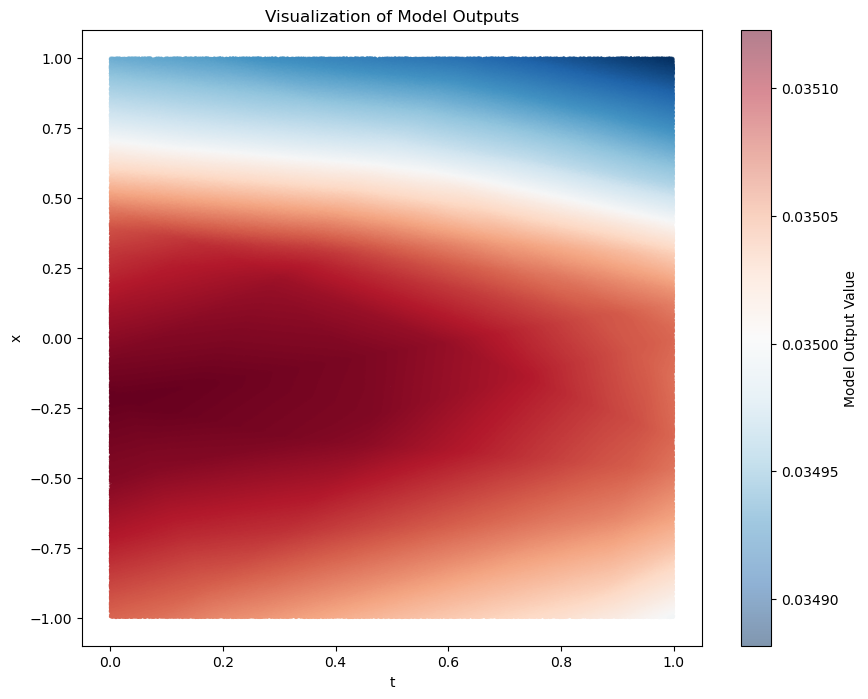

In [104]:
#Generate Random Points
num_points = 1000000
t_values = np.random.rand(num_points)
x_values = np.random.uniform(-1, 1, num_points)
points = np.vstack((t_values, x_values)).T
points_tensor = torch.tensor(points, dtype=torch.float32).to(device)



#Feed the Points through the Model
with torch.no_grad():
    model_outputs = pinn(points_tensor).cpu().numpy()
    #print(model_outputs)

print(model_outputs[20:])

# Normalize the model outputs to be between 0 and 1 for color mapping
normalized_outputs = (model_outputs - (-1)) / (1 - (-1))


#Plotting
plt.figure(figsize=(10, 8))
plt.scatter(t_values, x_values, c=model_outputs.squeeze(), cmap='RdBu_r', s=1, alpha=0.5)
plt.xlabel("t")
plt.ylabel("x")
plt.colorbar(label='Model Output Value')
plt.title("Visualization of Model Outputs")
plt.show()


Plotting x values again u(x)

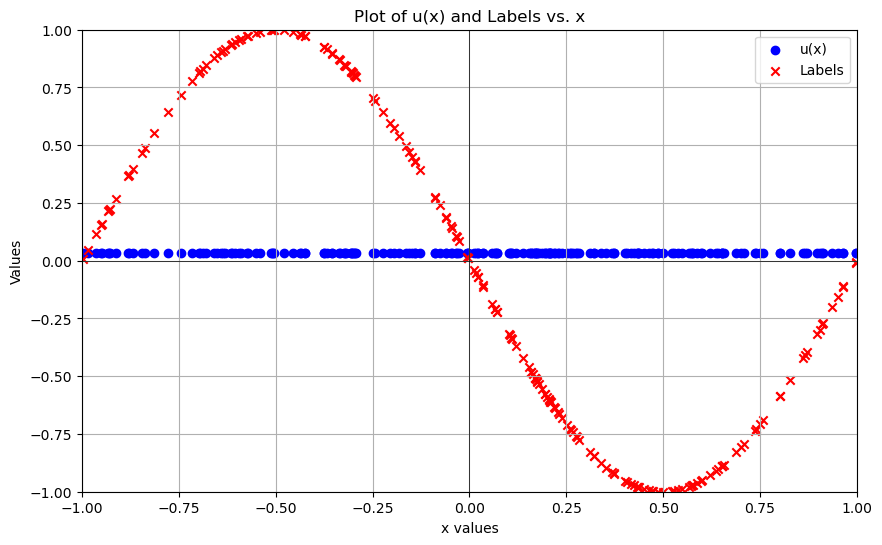

In [105]:
def plot_tensors(x, u, labels):
    # Convert tensors to numpy arrays
    x_np = x
    u_np = u

    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x_np, u_np, color='blue', marker='o', label='u(x)')
    
    if labels is not None:
        labels_np = labels
        plt.scatter(x_np, labels_np, color='red', marker='x', label='Labels')
    
    plt.title('Plot of u(x) and Labels vs. x')
    plt.xlabel('x values')
    plt.ylabel('Values')
    plt.grid(True)
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    plt.legend()
    plt.show()

# Example usage:
x = t_0_points[:,1]
u = pinn(torch.Tensor(t_0_points.astype(np.float32))).detach().numpy()

plot_tensors(x, u, t_0_labels)